In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import jax
from jax import vmap, jit
from fastprogress import progress_bar
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import bayes_ca.inference as core

In [2]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 3
num_features = 1
num_timesteps = 300

# model settings
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5 * sigmasq_pri   # Note: variance of jump size is 2 * sigmasq_pri
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

mu_pri = core._safe_handling_params(mu_pri, num_features)
sigmasq_pri = core._safe_handling_params(sigmasq_pri, num_features)
sigmasq_subj = core._safe_handling_params(sigmasq_subj, num_features)

In [3]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)

    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [4]:
@jit
def prox_update_global_mean(stepsize,
                            global_means,
                            subj_means, 
                            sigmasq_subj, 
                            mu_pri, 
                            sigmasq_pri, 
                            hazard_rates):
    # Use exponential family magic to compute gradient of the 
    # smooth part of the objective (not including the CP prior)
    _, _, _, expected_subj_means = core.gaussian_cp_smoother(
        global_means, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj)
    g = 1 / sigmasq_subj * jnp.sum(subj_means - expected_subj_means, axis=0)   # sum over subjects
    # jax.debug.breakpoint()

    # Compute the proximal update by taking a step in the direction of the gradient
    # and using the posterior mode to find the new global states
    effective_emissions = global_means + stepsize * g
    return core.gaussian_cp_posterior_mode(
        effective_emissions, hazard_rates, mu_pri, sigmasq_pri, jnp.repeat(stepsize, num_features))[1]

In [5]:
@jit
def step(key,
         stepsize,
         subj_obs, 
         sigmasq_obs, 
         global_means, 
         sigmasq_subj, 
         mu_pri, 
         sigmasq_pri, 
         hazard_rates):
    
    # Sample new subject means
    subj_means = gibbs_sample_subject_means(
        key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    # Update the global mean
    global_means = prox_update_global_mean(
        stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    
    return global_means, subj_means

## Create data with perfectly aligned subjects

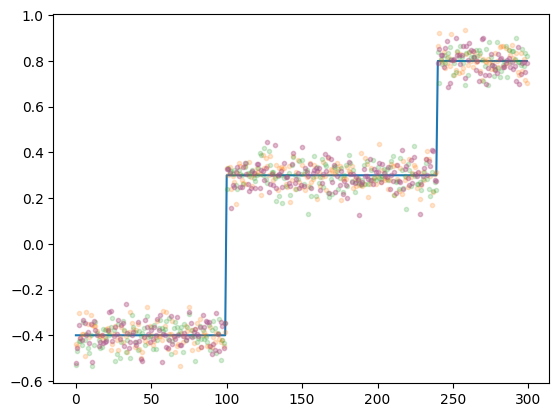

In [6]:
this_key, key = jr.split(key)
signal_one = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((140, 1)) * 0.30,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_one = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)

this_key, key = jr.split(key)
obs_two = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

this_key, key = jr.split(key)
obs_three = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)


obs = jnp.stack((obs_one, obs_two, obs_three), axis=0)

plt.plot(signal_one[...,0])
for i in range(4):
    plt.plot(obs[i], '.', alpha=0.2)

In [7]:
key = jr.PRNGKey(0)
init_global_means = jnp.ones((num_timesteps,num_features)) * 0.2
subj_means = gibbs_sample_subject_means(
    key, obs, sigmasq_obs, init_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

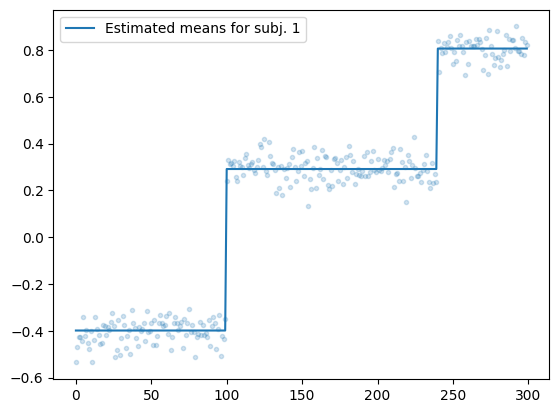

In [8]:
# plt.plot(signals.mean(axis=0))

for i in range(1, 2):
    l = plt.plot(subj_means[i], alpha=1, label=f'Estimated means for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

In [9]:
stepsize = 2.75
global_means = jnp.ones((num_timesteps, num_features)) * 0.2

# with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
for i in progress_bar(range(100000)):
    global_means = prox_update_global_mean(
        stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

Text(0.5, 1.0, 'Estimated global means, 99999 iterations')

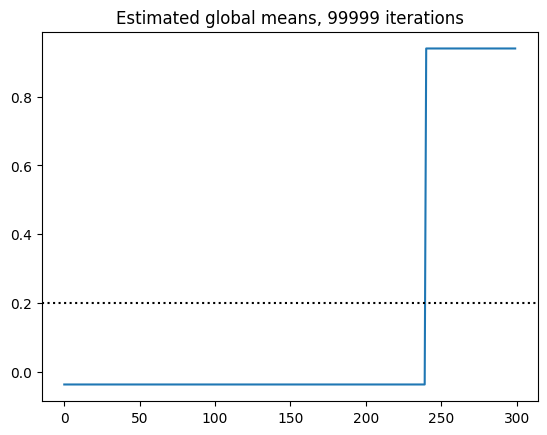

In [10]:
plt.plot(global_means)
plt.axhline(0.2, color='k', ls=':')
plt.title(f'Estimated global means, {i} iterations')

In [11]:
key = jr.PRNGKey(0)
stepsize = 2.75  # FIXME
global_means = jnp.ones((num_timesteps, num_features)) * 0.2

for itr in progress_bar(range(1000000)):
    this_key, key = jr.split(key)
    global_means, subj_means = step(
        this_key,
        stepsize,
        obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

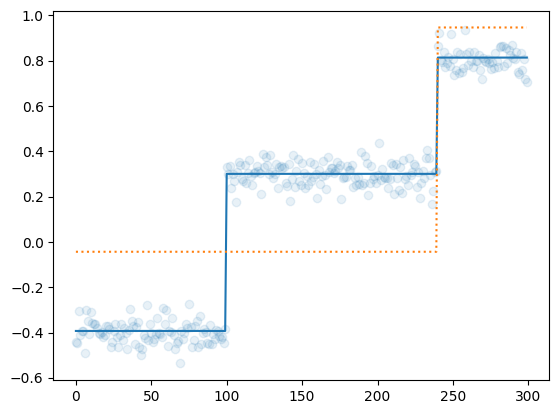

In [13]:
l = plt.plot(subj_means[0])[0]
plt.plot(obs[0], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, ':')

## Create data from second schematic figure

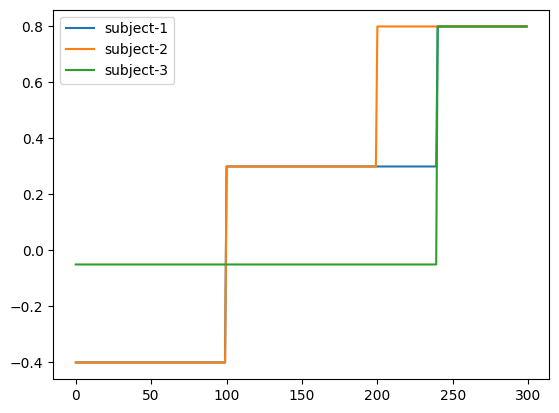

In [15]:
this_key, key = jr.split(key)
signal_one = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((140, 1)) * 0.30,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_one = tfd.Normal(signal_one, jnp.sqrt(sigmasq_obs)).sample(seed=key)

this_key, key = jr.split(key)
signal_two = jnp.concatenate(
    (
        jnp.ones((100, 1)) * -0.40,
        jnp.ones((100, 1)) * 0.30,
        jnp.ones((100, 1)) * 0.80,
    )
)
obs_two = tfd.Normal(signal_two, jnp.sqrt(sigmasq_obs)).sample(seed=this_key)

this_key, key = jr.split(key)
signal_three = jnp.concatenate(
    (
        jnp.ones((240, 1)) * -0.05,
        jnp.ones((60, 1)) * 0.80,
    )
)
obs_three = tfd.Normal(signal_three, jnp.sqrt(sigmasq_obs)).sample(seed=key)


plt.plot(signal_one[...,0], label='subject-1')
plt.plot(signal_two[...,0], label='subject-2')
plt.plot(signal_three[...,0], label='subject-3')
plt.legend()

In [16]:
signals = jnp.stack((signal_one, signal_two, signal_three), axis=0)
obs = jnp.stack((obs_one, obs_two, obs_three), axis=0)

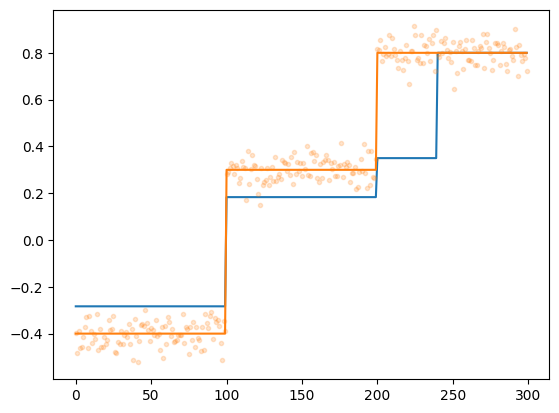

In [17]:
plt.plot(signals.mean(axis=0))

for i in range(1, 2):
    l = plt.plot(signals[i], alpha=1)[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
# plt.xlim(0, 250)

## Sample conditional distribution for each subject

The effective observations for each subject are the weighted average of its observations and the global mean.

In [18]:
key = jr.PRNGKey(0)
init_global_means = jnp.ones((num_timesteps,num_features)) * 0.2
subj_means = gibbs_sample_subject_means(
    key, obs, sigmasq_obs, init_global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

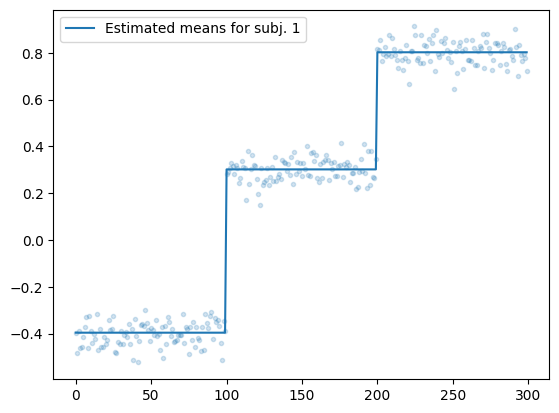

In [19]:
# plt.plot(signals.mean(axis=0))

for i in range(1, 2):
    l = plt.plot(subj_means[i], alpha=1, label=f'Estimated means for subj. {i}')[0]
    plt.plot(obs[i], '.', color=l.get_color(), alpha=0.2)
plt.legend()

## Compute gradient with respect to the global mean

In [27]:
stepsize = 2.75
global_means = jnp.ones((num_timesteps, num_features)) * 0.2

# with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
for i in progress_bar(range(1000000)):
    global_means = prox_update_global_mean(
        stepsize, global_means, subj_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)
    # if not jnp.allclose(global_means, step_means, atol=1e-9):
    #     global_means = step_means
    # else:
    #     global_means = step_means
    #     break

Text(0.5, 1.0, 'Estimated global means, 999999 iterations')

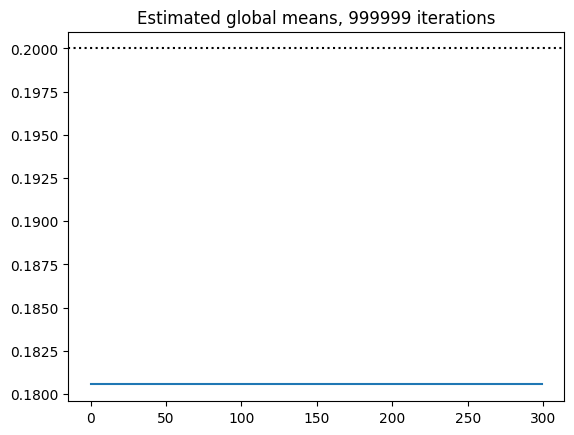

In [28]:
plt.plot(global_means)
plt.axhline(0.2, color='k', ls=':')
plt.title(f'Estimated global means, {i} iterations')

In [29]:
jnp.unique(global_means)

Array([0.18055737], dtype=float32)

## Put both steps together

In [31]:
key = jr.PRNGKey(0)
stepsize = 3.0  # FIXME
global_means = jnp.ones((num_timesteps, num_features)) * 0.2

for itr in progress_bar(range(100000)):
    this_key, key = jr.split(key)
    global_means, subj_means = step(
        this_key,
        stepsize,
        obs, 
        sigmasq_obs, 
        global_means, 
        sigmasq_subj, 
        mu_pri, 
        sigmasq_pri, 
        hazard_rates
    )

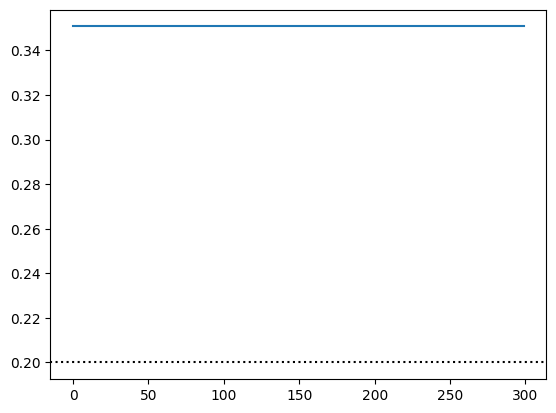

In [32]:
plt.plot(global_means)
plt.axhline(0.2, color='k', ls=':')

In [33]:
jnp.unique(global_means)

Array([0.35075745], dtype=float32)

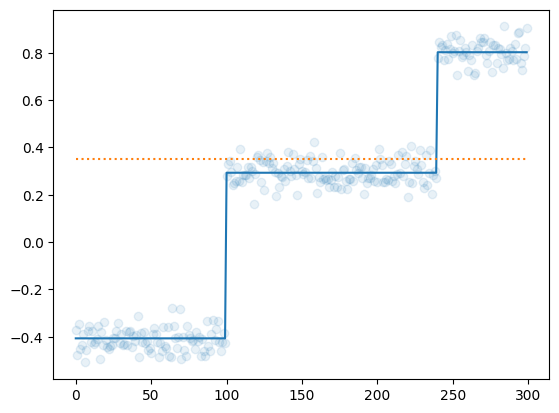

In [34]:
l = plt.plot(subj_means[0])[0]
plt.plot(obs[0], 'o', color=l.get_color(), alpha=0.1, lw=3)
plt.plot(global_means, ':')
